In [31]:
import os
import csv
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

### Funciones para analizar atomos

In [32]:
# Editar el archivo XML
def clean_xml(book_file_path):
    with open(book_file_path, 'r', encoding='ISO-8859-1') as file:
        lines = file.readlines()

    # Encontrar la linea donde comienza el bloque <book>
    start_index = None
    for i, line in enumerate(lines):
        if line.strip().startswith('<book'):
            start_index = i
            break

    if start_index is not None:
        # Mantener la primera linea
        cleaned_lines = [lines[0]] + lines[start_index:]

        # Reescribir el libro limpio
        with open(book_file_path, 'w', encoding='ISO-8859-1') as file:
            file.writelines(cleaned_lines)

# Definir parametros y atributos de los atomos
def set_param(book_file_path, Si, dictionary, n_atoms, snr):
    tree = ET.parse(book_file_path)
    root = tree.getroot()
    # Obtener los resultados del libro en la descomposicion
    initial_energy = float(root.find("param[@name='initialEnergy']").get('value'))
    residual_energy = float(root.find("param[@name='residualEnergy']").get('value'))
    snr_f = float(root.find("param[@name='SNR']").get('value'))
    nAtoms = int(root.get("nAtom"))
    
    atoms = []
    for atom in root.findall('atom'):
        type = atom.get('type')
        num_chans = int(atom.find("par[@type='numChans']").text)
        pos = int(atom.find("support[@chan='0']/p").text)
        len = int(atom.find("support[@chan='0']/l").text)
        amp = float(atom.find("par[@type='amp'][@chan='0']").text)
        freq = float(atom.find("par[@type='freq']").text)
        chirp = float(atom.find("par[@type='chirp']").text)
        phase = float(atom.find("par[@type='phase'][@chan='0']").text)
        window_type = atom.find("window").get('type')
        window_opt = int(atom.find("window").get('opt'))

        atoms.append({
            'type': type,
            'num_chans': num_chans,
            'pos': pos,
            'len': len,
            'amp': amp,
            'freq': freq,
            'chirp': chirp,
            'phase': phase,
            'window_type': window_type,
            'window_opt': window_opt,
            'nAtoms': nAtoms,
            'maxAtoms': n_atoms,
            'SNRf': snr_f,
            'SNR': snr,
            'initialEnergy': initial_energy,
            'residualEnergy': residual_energy,
            'dictionary': dictionary,
            'S': Si
        })
    return atoms

# Construir un atomo gaussiano
def gaussian_atom(position, length, amplitude, frequency, phase, chirp, size=1712, sample_rate=8000):
    x = np.zeros((size,))
    t = np.arange(length)
    modulation = np.cos(2 * np.pi * (chirp * (t**2)/2 + frequency * t) + phase)

    t = t - (length - 1)/2
    sigma = 0.04 * ((length + 1)**2)
    sigma_G = 1/sigma
    window = np.exp(-sigma_G * (t**2))

    energy_w = np.sqrt(np.sum(window**2))
    window = window/energy_w
    atom = amplitude * window * modulation
    x[position - 1 : position + length - 1] = atom
    return x, atom

# Escribir archivo CSV
def atoms_to_csv(atoms, csv_file_path):
    fieldnames = ['type', 'num_chans', 'pos', 'len', 'amp', 'freq', 'chirp', 'phase', 'window_type', 'window_opt', 
                  'nAtoms', 'maxAtoms', 'SNRf', 'SNR', 'initialEnergy', 'residualEnergy', 'dictionary', 'S']
    exists = os.path.isfile(csv_file_path)

    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Escribir header si no existe el CSV
        if not exists:
            writer.writeheader()

        for atom in atoms:
            writer.writerow(atom)

# Graficar los atomos
def plot_results(atoms):
    plt.figure(figsize=(10, 6))
    for atom in atoms:
        x, y = gaussian_atom(atom['pos'], atom['len'], atom['amp'], atom['freq'], atom['phase'], atom['chirp'])
        plt.plot(x)
    
    plt.title("Atomos Gaussianos")
    plt.xlabel("Posicion")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()

# Single Book Atoms Analysis

### Especificar directorios

In [33]:
# Parametros y diccionario
Si = "S1"
test = "7"
filename = "New_N_187_3_S1.wav"
dict = "dic_gabor_v1.xml"
n = 40
snr = 25 

# Cargar el libro
book_file_path = fr'c:\Users\Juan Carlos\Documents\DSP\Test{test}\Book_{Si}\book_{filename}.xml'

# Direccion para escribir CSV
csv_file_path = fr"c:\Users\Juan Carlos\Documents\DSP\Test{test}\AtomsCSV\Atoms_{filename}.csv"

### Ejecutar Procesos

In [34]:
# Procesar el archivo XML
atoms = set_param(book_file_path, Si, dict, n, snr)
# Escribir csv
atoms_to_csv(atoms, csv_file_path)

# Imprimir
for atom in atoms:
    print(atom, "\n")

{'type': 'gabor', 'num_chans': 1, 'pos': 640, 'len': 512, 'amp': 8.31978, 'freq': 0.00976563, 'chirp': 0.0, 'phase': 0.432463, 'window_type': 'gauss', 'window_opt': 0, 'nAtoms': 25, 'maxAtoms': 40, 'SNRf': 25.3679, 'SNR': 25, 'initialEnergy': 57.5274, 'residualEnergy': 0.167143, 'dictionary': 'dic_gabor_v1.xml', 'S': 'S1'} 

{'type': 'gabor', 'num_chans': 1, 'pos': 384, 'len': 512, 'amp': 3.89224, 'freq': 0.0078125, 'chirp': 0.0, 'phase': -2.25042, 'window_type': 'gauss', 'window_opt': 0, 'nAtoms': 25, 'maxAtoms': 40, 'SNRf': 25.3679, 'SNR': 25, 'initialEnergy': 57.5274, 'residualEnergy': 0.167143, 'dictionary': 'dic_gabor_v1.xml', 'S': 'S1'} 

{'type': 'gabor', 'num_chans': 1, 'pos': 768, 'len': 512, 'amp': 3.75411, 'freq': 0.00976563, 'chirp': 0.0, 'phase': 2.55474, 'window_type': 'gauss', 'window_opt': 0, 'nAtoms': 25, 'maxAtoms': 40, 'SNRf': 25.3679, 'SNR': 25, 'initialEnergy': 57.5274, 'residualEnergy': 0.167143, 'dictionary': 'dic_gabor_v1.xml', 'S': 'S1'} 

{'type': 'gabor', 'nu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


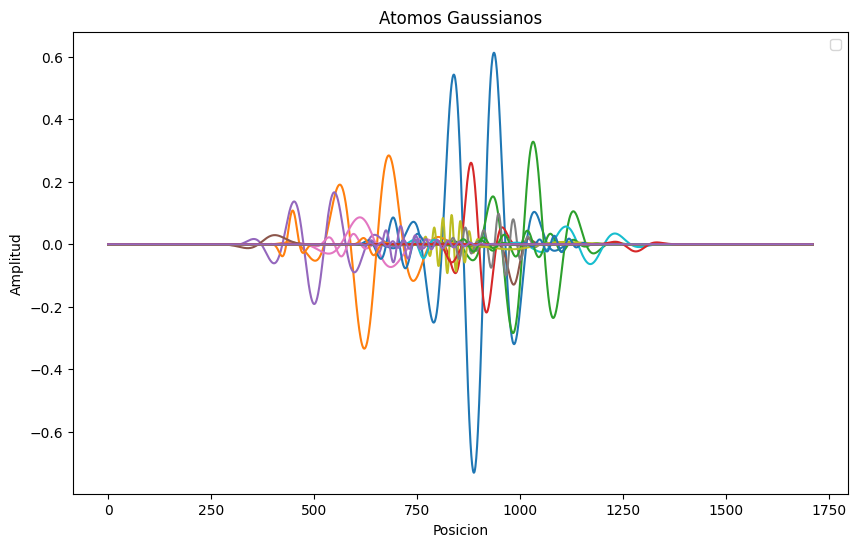

In [35]:
# Graficar
plot_results(atoms)

### Reconstruccion Manual

In [36]:
# Crear reconstruccion manual y graficar
def manual_recons_plot(atoms):
    plt.figure(figsize=(10, 6))
    s = np.zeros((1712,))
    
    for atom in atoms:
        x, y = gaussian_atom(atom['pos'], atom['len'], atom['amp'], atom['freq'], atom['phase'], atom['chirp'])
        s += x
    
    # Graficar
    plt.plot(s, label="Reconstructed PCG")
    plt.title("Reconstruccion a partir de los atomos de Gabor")
    plt.xlabel("Posicion")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()
    return s

# Graficar y comparar
def plot_results(original_signal, reconstructed_signal, manual_rec, error):
    plt.figure(figsize=(12, 6))
    y_min = min(min(original_signal), min(reconstructed_signal))
    y_max = max(max(original_signal), max(reconstructed_signal))

    plt.subplot(4, 1, 1)
    plt.plot(original_signal, label='Signal')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(reconstructed_signal, label='Reconstructed PCG')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(manual_rec, label='Manual')
    plt.ylim(y_min, y_max)
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(error, label='Error')
    plt.ylim(y_min, y_max)
    plt.legend()

    plt.show()

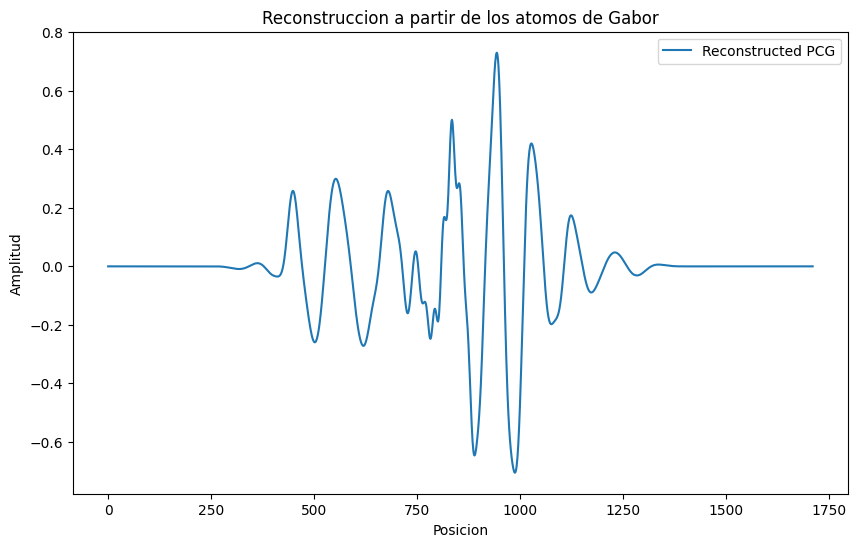

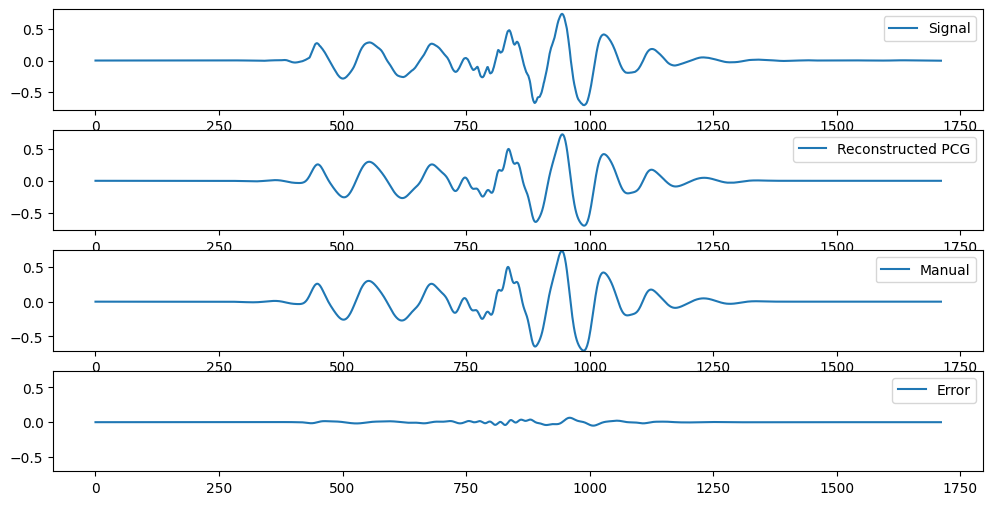

In [37]:
# Graficar
s = manual_recons_plot(atoms)

# Señal original 
signal_add = fr"c:\Users\Juan Carlos\Documents\DSP\Test{test}\{Si}\{filename}"
original_signal, sr = sf.read(signal_add)
reconstructed_add = fr"c:\Users\Juan Carlos\Documents\DSP\Test{test}\Reconstructed_{Si}\reconstructed_{filename}.wav"
reconstructed_signal, srr = sf.read(reconstructed_add)
plot_results(original_signal, reconstructed_signal, s, (reconstructed_signal - s) )